# Final Processing
The final processing stage requires:
1. Quick validation of blind catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue
4. Merging MF catalogue with XID+ flux densities

In [135]:
import seaborn as sns
from astropy.table import Table,hstack
%matplotlib inline
import numpy as np
import pylab as plt

from astropy import units as u
from astropy.table import Column

import herschelhelp_internal
from herschelhelp_internal.utils import gen_help_id
import numpy.core.defchararray as np_f


## Read tables

In [136]:
cat=Table.read('./data/dmu22_XID+SPIRE_SA13_BLIND.fits')
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [137]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
8,197.855149993,42.5671160212,67.8592,70.8763,64.6702,61.9552,63.8792,59.3428,45.0168,49.4403,40.5577,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.999346,0.999348,0.998874,2000.0,2000.0,2000.0,0.0,0.0,0.0
16,197.893045015,42.4977312992,44.0255,48.5561,39.9203,31.6237,35.3951,27.8582,19.0988,23.9203,14.2767,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.999268,0.998481,0.999528,2000.0,2000.0,2000.0,0.0,0.001,0.0
23,197.952630645,42.4605772106,47.8785,52.8323,42.9732,36.9955,41.9094,32.1833,44.4419,51.9702,37.1096,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.999853,0.999552,0.998209,2000.0,2000.0,2000.0,0.0,0.001,0.0
35,197.864409222,42.49879897,29.5685,34.166,25.0656,27.9472,31.6208,24.1863,7.34832,11.0765,3.43822,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.999546,1.00016,1.00098,2000.0,2000.0,2000.0,0.0,0.0,0.0
66,197.897155093,42.5113478736,47.7785,52.0938,43.4461,70.8185,74.0807,67.4937,58.0083,62.633,53.7125,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.99885,1.00044,1.00039,2000.0,2000.0,2000.0,0.0,0.001,0.0
101,197.930695344,42.5099996023,25.2612,28.7756,21.9671,21.5853,25.5749,17.6083,15.1688,19.4054,10.742,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,1.00196,1.0018,0.999545,2000.0,2000.0,2000.0,0.0,0.0,0.0
105,197.931033478,42.5297219563,21.7857,25.296,18.4972,30.4202,33.3535,27.3395,24.3927,28.5369,20.1483,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,0.999197,1.00171,0.999674,2000.0,2000.0,2000.0,0.0,0.007,0.0
123,198.002314994,42.4806095401,17.5904,22.2433,12.9469,2.89647,6.45764,0.853462,5.1742,9.7608,1.88636,-0.0708282,-0.0872433,-0.05502,0.005978,0.00867867,0.0115186,1.0002,0.999584,1.00069,2000.0,2000.0,2000.0,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


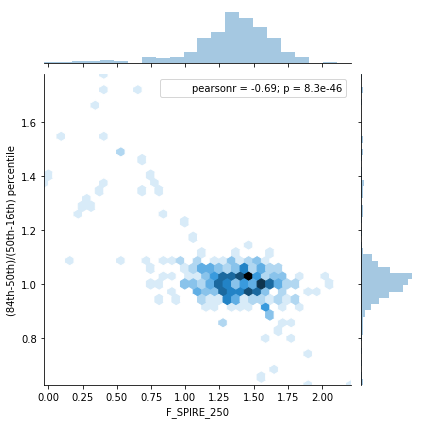

In [138]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')

For 250 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


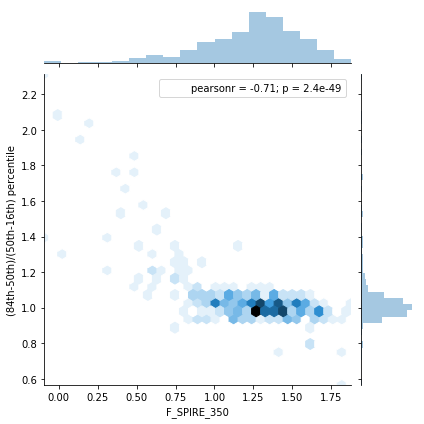

In [139]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')


For 350 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


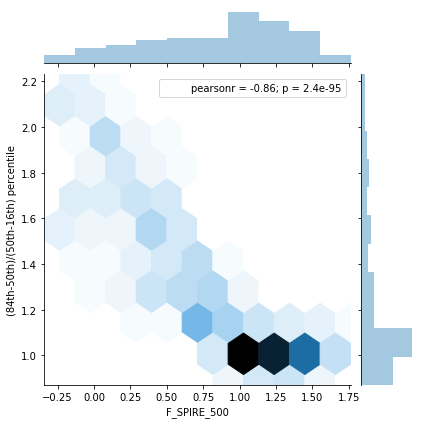

In [140]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')


For 500 $\mathrm{\mu m}$ depth is ~ 6mJy

## Add flag to catalogue

In [141]:
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [142]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 6)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 6)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 6)

In [143]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

27 36 127 315


In [144]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [145]:
# set XID+ cahtalogue back to orignal order of objects, as used in MF detection files
use = cat['HELP_ID'].astype(int) -1
use = np.argsort(use)
cat = cat[use]

In [146]:
# Reads MF table, removes duplicate RA and DEC
cat2=Table.read('./data/SA13_SPIRE_all.fits')
del cat2['RA']
del cat2['Dec']
cat_all = hstack([cat,cat2])

In [147]:
# Created HELP_ID, and changes HELP to HELP_BLIND to avoid confusion with HELP-Masterlist objects
ID = gen_help_id(cat_all['RA'], cat_all['Dec'])
ID_new = [IDs.replace('HELP','HELP_BLIND') for IDs in ID]
ID_new = Column(ID_new,name="HELP_ID")
cat_all['HELP_ID'] = ID_new

In [148]:
# all flux denisties are in mJy in the final BLIND cahtalogues
cat_all['F_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_250'] = 1000*cat_all['F_BLIND_MF_SPIRE_250']
cat_all['FErr_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_250'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_250']

cat_all['F_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_350'] = 1000*cat_all['F_BLIND_MF_SPIRE_350']
cat_all['FErr_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_350'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_350']

cat_all['F_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_500'] = 1000*cat_all['F_BLIND_MF_SPIRE_500']
cat_all['FErr_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_500'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_500']

cat_all['F_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['F_BLIND_pix_SPIRE'] = 1000*cat_all['F_BLIND_pix_SPIRE']
cat_all['FErr_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['FErr_BLIND_pix_SPIRE'] = 1000*cat_all['FErr_BLIND_pix_SPIRE']


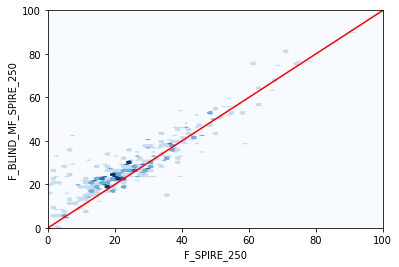

In [149]:
# XID+ flux density vs. MF flux densities
plt.hexbin(cat_all['F_SPIRE_250'],cat_all['F_BLIND_MF_SPIRE_250'], cmap=plt.cm.Blues,gridsize=(100,100))
plt.plot([0,100],[0,100], color = 'red')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('F_SPIRE_250')
plt.ylabel('F_BLIND_MF_SPIRE_250')
plt.show()


In [150]:
# Add field name
cat_all.add_column(Column(['SA13']*len(cat_all),name='field'))


In [151]:
cat_all.write('./data/dmu22_XID+SPIRE_SA13_BLIND_Matched_MF.fits', format='fits',overwrite=True)